<a href="https://colab.research.google.com/github/Leila828/Learning_JAX_for_deepLearning/blob/main/jax_JAX_Ecosystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*italicised text*# **Introduction to JAX Ecosystem**

At this point in the course, JAX doesn’t seem much like a specialized neural network library, despite its wide suite of features. This is understandable given JAX, at its core, is a parallelizable NumPy with a number of other features.

The story doesn’t conclude there, though. In order to facilitate deep learning, JAX has its own ecosystem of libraries, comprising of:

Haiku
Optax
Jraph
RLax
Chex
Each of these libraries deserves a chapter of its own, and even that would be unable to fully unpack their particular details. However, we’ll just provide a brief overview of each in this introductory course.

**Note: Flax is a library for neural networks but is usually not considered part of the JAX ecosystem**

**Introduction to Flax and Linen**

While JAX has powerful features, coding our deep learning applications can still be tricky. This isn’t surprising, since JAX is intended to be a generic numeric computational library.

JAX does offer some pretty useful libraries for designing neural networks, though. We’ll review them in this chapter and consolidate our understanding to build the project at the conclusion.

# **Flax#**
As a high-performance neural network library, Flax aims to provide flexible designs while coding in JAX.

The main packages in Flax are:

Neural networks
Utilities

# **Neural networks#**
The package flax.linen is used for all the required neural network classes. Because of the wide range of functionalities for neural networks, we’ll restrict ourselves to only the most relevant ones here.

The use of flax.nn is obsolete and shouldn’t be confused with flax.linen.

Linen philosophy#
Linen designers acknowledge that PyTorch and Tensorflow are already established 


libraries in the deep learning community, so there is little need to build a clone of either.

Note: This section is more about Linen’s philosophy and can be skipped without any loss of continuity.

Flax Linen instead focuses on the strength of JAX -
−
 beauty of working with the pure functions -
−
 and allows us to:


*   Use vmap() for auto-vectorization of batches.
*   Handle ragged batches in NLP.
*   Increase the efficiency of convolutional neural networks by utilizing rematerialized scan.
*   Remove memory headaches.



# **Interoperability with JAX transforms**

JAX operates on pure functions, which means we cannot mutate the state of the input variable. This restriction can be troublesome while making a neural network since it can have tons of parameters changing in each iteration. In order to overcome this hindrance, Linen modules are designed to be re-functionalized -
−
 they can be recast (in-place) as explicit functions:


f(v_{in},x)\to v_{out},y
f(v 
in
​
 ,x)→v 
out
​
 ,y

 

“Code shouldn’t get in the way.” One should remember that purely functional code is unhampered by the above feature. We can use Linen modules inside them without any modification.

# **Parameters representation**


Similar to other libraries, Flax uses the power of Pytrees for storing the (neural network) parameters.

**Module class#**


This is our base class, while making a neural network. All layers and modules should inherit from it.

In [ ]:
import flax.linen as nn

class MyNeuralNetwork(nn.Module):
  def FuncA():
    print('Dummy function A')
  def FuncB():
    print('Dummy function B')

Here is an overview of its common methods. They will come in handy while designing neural networks.

**setup()**#

Since the Module class itself inherits from the Python (3.7
3.7
+) data classes, we cannot use __init__() and should prefer setup() as the initializer or constructor.

In [ ]:
import flax.linen as nn

class MyNeuralNetwork(nn.Module):
  def FuncA():
    print('Dummy function A')
  def FuncB():
    print('Dummy function B')
  def setup(self):
    print('Just dummy function.')


We can use the call() method to define the forward pass of the defined subclass. It allows us to use its objects as if they are functions.



**init()#**

In order to initialize a method, we can use init(). This method takes in three parameters:

PRNG Key: For random initialization
Method to initialize: If no method is specified, it defaults to __call__().
Mutables: We can still keep control over which collections should be treated as mutable or not. It’s optional as well and can be discarded altogether.

In [ ]:
import flax.linen as nn
from jax import random

class MyNeuralNetwork(nn.Module):
  def FuncA():
    print('Dummy function A')
  def FuncB():
    print('Dummy function B')
  def setup(self):
    print('Setup method.')
  def __call__(self):
    print('Call method')

mynn = MyNeuralNetwork()

key = random.PRNGKey(27)
mynn.init(key)

**apply()#**

The init() is complemented by apply() which takes a variable(s) and applies the desired method. Its parameters are the same as init(), though it takes the variables, represented as a dictionary.

Modules have a restriction denying the submodules definition within a method and to pass it, we can designate a method as compact by the @compact decorator.

**bind()#**
We have a non-functional counterpart of apply() as well by binding variables and PRNGs.

The bind(), unlike apply(), doesn’t transform the function and instead provides an interactive instance of the module. It also converts the variables into stateful objects and consequently, it violates the purely functional paradigm of JAX. It is strongly discouraged in production use.

# **Variables#**
The aforementioned variable dictionary is worth a second look. It is a normal Python dictionary (recursion allowed) having JNP arrays as its leaves. For example, consider this variable dictionary:

In [ ]:
{
  "params": {
    "Conv1": { "weight": ..., "bias": ... },
    "BatchNorm1": { "scale": ..., "mean": ... },
    "Conv2": {...}
  },
  "hyperParams": {
    "BatchNorm1": { "movingMean": ..., "movingAverage": ...}
    "Optim": { "algorithm": ..., "learningRate": ...}
  }
}

As we can see, we are using the nested structure. It’s totally okay to have a parameter in two different collections (like BatchNorm1).

**param()#**

The params is a default collection of immutable objects. We can simply use param() to define any variable -
−
 like Conv1, above -
−
 in the collection.

Its parameters are:

* Name
* Initialization method
* Initialization arguments
For example, we can define the Conv2 parameter as:

In [ ]:
v2 = self.param('Conv2', FuncXYZ(), jnp.ones((256,256)))

where FuncXYZ() and the 256×256
 jnp array are the initialization method and arguments.

Note: Initialization method does take the PRNG key here as well, but it is implicitly taken from the init() method.

**variable()#**
If we want to generalize the parameter definition to any collection of choice (like batch_stats above), we can use variable() as a counterpart of param(). There are three differences between the two:

*  variable() requires the explicit passing of the PRNG key as well.
*  Collection’s name should be specified as the leading argument.
*  All the variables in the resulting collection are mutable.


For example, we can define the aforementioned Optim hyperparameter as:

In [ ]:
key = jax.random.PRNGKey(35)
v3 = self.param('hyperParams', 'Optim', AdamInitializer(), key, AdamDict)
#We need to explicitly specify the keys for collections other than params

where AdamInitalizer() and AdamDict are the respective initialization methods and arguments.

# **Flax: Linear Modules**

This lesson will focus on linear modules. These modules are helpful in designing feedforward neural networks. For simplicity, we’ll omit the optional arguments.

**Dense layers#**


We can use Dense() to apply an affine transformation to the previous layer, x
x
 as:

y=w^Tx+b
y=w 
T
 x+b

Since Dense() applies a transformation only to the last dimension of the previous layer matrix, we can generalize it to any dimension by this function. For example, we can apply linear transformation along the required dimension through:

y = DenseGeneral(x,axis=<>)

Note: Most documentation incorrectly term the affine transformation as a linear transformation. This lesson will refer to them as affine thereon. (For further reading, check any linear algebra book such as Boyd’s Applied Linear Algebra (2018).)

If we print the output of a dense layer, some extra parameters will also be on display. Some of them are pretty helpful, like:

**use_bias** controls whether or not to use the bias. It’s true by default.

**kernel_init** is the function to initialize the weight matrix, w
w

In [ ]:
import flax.linen as nn

x = jnp.ones((5,10))
y = nn.Dense(x)
print(y)
z = nn.DenseGeneral(x, axis=2)
print(z)

**Activations**

Suppose we have an affine transformation over the input x
x
 as:

y=w_1^Tx+b_1
y=w 
1
T
​
 x+b 
1
​


If we extend this by applying another affine transformation, it will transform into:

z=w_2^T(w_1^Tx+b_1)+b_2 = w_2^Ty+b_2
z=w 
2
T
​
 (w 
1
T
​
 x+b 
1
​
 )+b 
2
​
 =w 
2
T
​
 y+b 
2
​
 

Now, this is another affine function. No matter how many affine layers we add, our result is still an affine function.

Real-life problems can be extremely complex, but even for relatively simple problems like fitting a 2^{nd}
2 
nd
 
 order polynomial, we have to switch to non-linearity.

Activation functions serve the purpose of switching to non-linearity. Researchers have discovered a handful of them in the history of deep learning. Some of them are explained below:

Note: JAX uses a lower-case notation for the activation functions nomenclature.

**Sigmoid**

Sigmoid is defined as:

\sigma(x) = \frac{1}{1+e^{-x}}
σ(x)= 
1+e 
−x
 
1
​
 

Let’s calculate the value of Sigmoid for, say, 5:

\sigma(5) = \frac{1}{1+e^{-5}} = 0.9933
σ(5)= 
1+e 
−5
 
1
​
 =0.9933

Similarly, \sigma(-5)
σ(−5)
 will yield a value of 0.0067.



This means that the majority -
−
 more than 98% -
−
 of Sigmoid’s output corresponds to an extremely narrow domain of (-5,5)
(−5,5)
, which can lead to some serious problems while training the neural networks, as we’ll shortly see.

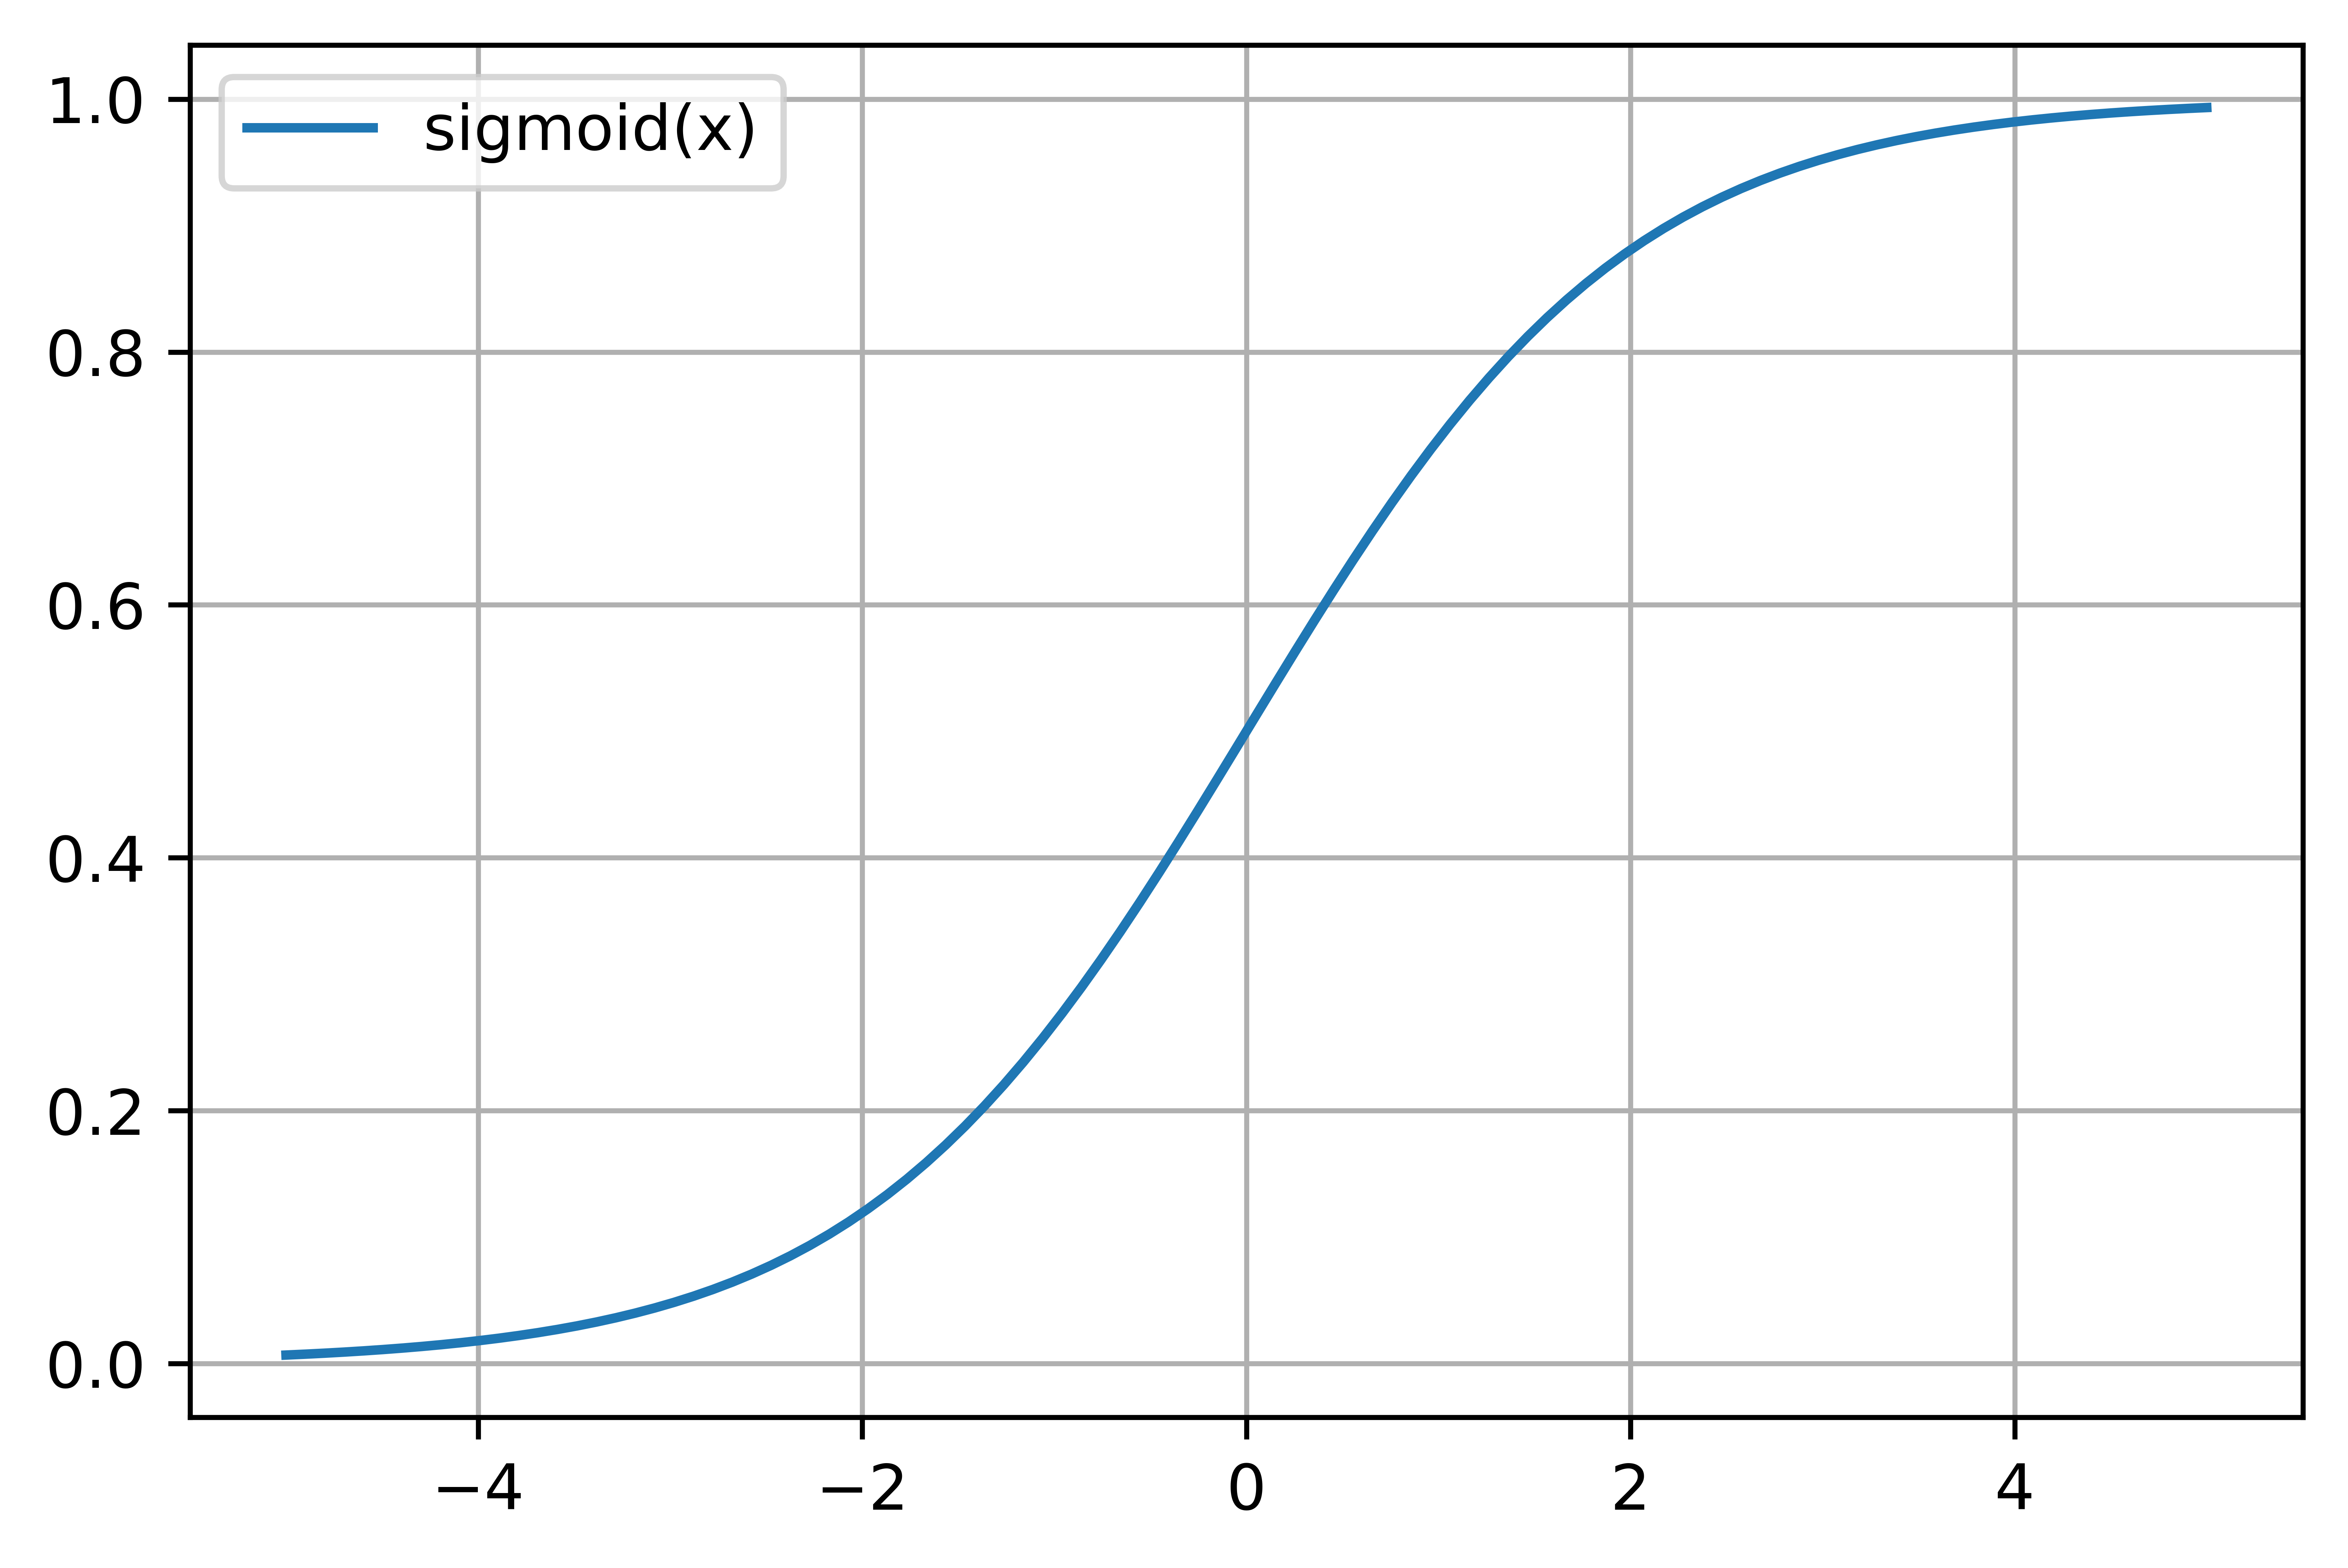

**Hyperbolic tangent**

Hyperbolic tangent, \tanh(x)
tanh(x)
 is a similar function.

\tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}
tanh(x)= 
e 
x
 +e 
−x
 
e 
x
 −e 
−x
 
​
 

While, Sigmoid is constrained between [0,1]
[0,1]
, tanh has a range of [-1,+1]
[−1,+1]
.

This property is useful in some computer vision applications for rescaling an image before input.

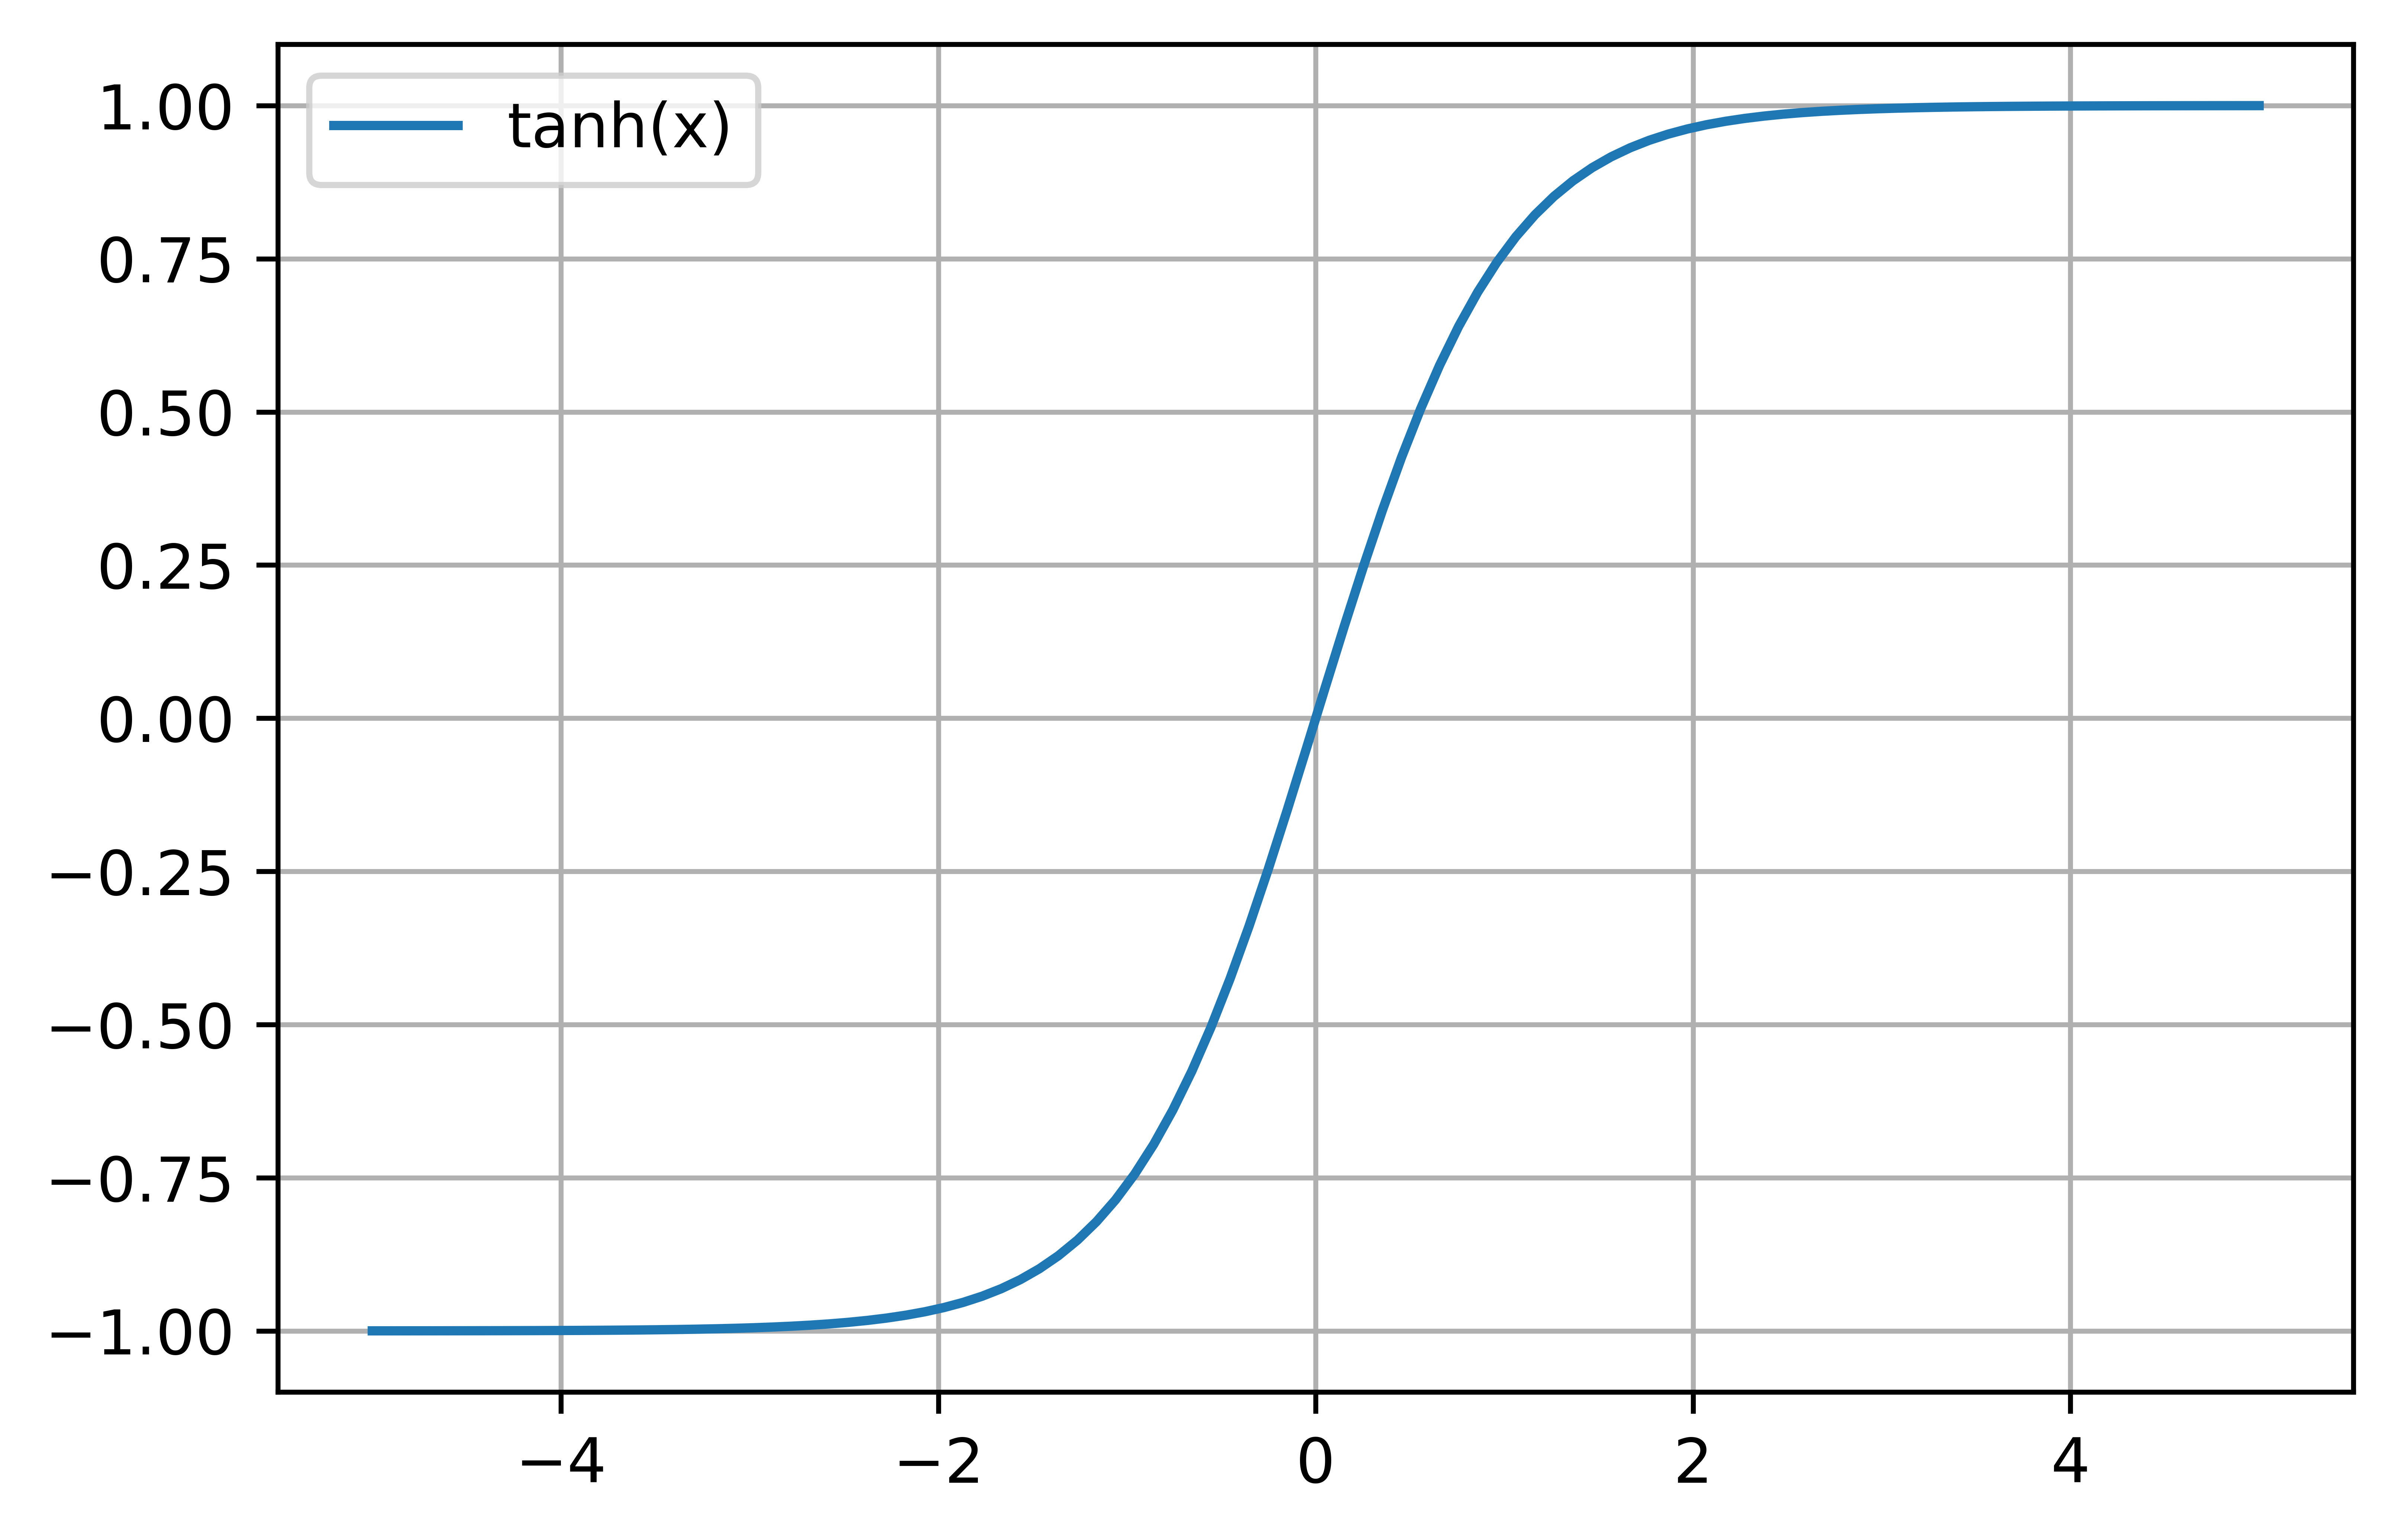

In [ ]:
import flax.linen as nn

key = random.PRNGKey(0)
A = random.normal(key,(100,100))
#Can uncomment lines below to verify the consistency of A and B's stats
#print(A.mean())   
#print(jnp.var(A))

B = nn.Dense(A)
print("---Stats of B----")
print("Mean is: ", B.features.mean())
print("Variance: ", jnp.var(B.features))

#Now try the same with the Sigmoid function

C = nn.sigmoid(A)
print("----Stats of C----")
print("Mean: ", C.mean())
print("Variance is: ", jnp.var(C))

D = nn.tanh(A)
print("----Stats of D----")
print("Mean: ", D.mean())
print("Variance is: ", jnp.var(D))

# **Rectified-Linear Unit (ReLU)#**

As we have seen, more than 98% of Sigmoid lies in a pretty narrow domain, and this is equally true for the tanh. This means that the gradient for values outside this narrow range will have a small value. Since we keep on multiplying the terms in backpropagation, this leads to very slow (or no) training. This is a phenomenon known as vanishing gradients.

Rectified Linear Unit, or ReLU fixes it by using a non-saturating non-linearity.

ReLU(x) = \begin{cases}x & \mathrm{for}\:x \ge 0\\0 & \mathrm{otherwise}\end{cases}
ReLU(x)={ 
x
0
​
  
forx≥0
otherwise
​
 

=\mathrm {max}(x,0)
=max(x,0)

ReLU was a revelation in deep learning’s brief history. Not only does it address the vanishing gradients issue, but it helps train at a faster rate as well. Check the AlexNet paper for example.

**Softmax#**

For multiclass classification problems, we have to output a number of probabilities (for each class) and pick out the most probable class. Softmax, a generalization of logistic function for multiclass problems, is useful for this. It is defined as:

Softmax(x) = \frac{e^{x_i}}{\sum_j {e^{x_j}} }
Softmax(x)= 
∑ 
j
​
 e 
x 
j
​
 
 
e 
x 
i
​
 
 
​
 

The intuition behind calling it Softmax is the ability of exponential functions to make the largest contribution much more prominent than the others.

**Embedding layers#**
The embedding layer is quite useful in a number of tasks, especially NLP. This function requires the input as well as the number of embeddings -
−
 for example, y = Embed(256,x).

**Dropout#**

Dropout is a regularization technique in which we try to minimize the reliance on a particular neuron’s value (and hence overfitting) by “freezing” a chunk of them in each iteration. These “freezing” neurons are selected randomly using a pre-defined probability. We can easily add a Dropout layer as Dropout(r), where r shows the Dropout rate.

Note: In most of the DL libraries we provide the keep probability instead of the Dropout rate, so be careful.

In [ ]:
z = nn.Dropout(rate=0.3) #will keep 70%
z = nn.Dense(z)
print(z)

# **Normalization#**
In 1998, Yann LeCun realized that the training of a neural network converges faster if its inputs are transformed to standard normal distribution, \mathcal N(0,1) -
N(0,1)−
 a process often termed as whitening the input. Researchers in the following years came to similar conclusions.

In 2015, Sergey Ioffe and Christian Szegedy formalized these findings to propose Batch Normalization, which has since become a typical standard in deep neural networks (especially CNNs).

We can simply add a Batch Normalization layer as:

y=BatchNorm()

Some useful parameters are:

* Running average, which indicates whether to use a running average or not.
* Momentum whose default is 0.99.
* Epsilon (\varepsilon
ε
), whose default is 10^{-5}
10 
−5
 
.
For a detailed list of the parameters, feel free to have a look at the output below.

In [ ]:
x = jnp.ones((5,10))
y = nn.Dense(x)

z = nn.BatchNorm(y)
print(z)

Nitish Srivastava, et al., Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)

Philip Isola, et al., Image-to-Image Translation with Conditional Adversarial Networks (2017)

Yann LeCun, et al., Efficient Backprop (1998)

Sergey Ioffe and Christian Szegedy, Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (2015)

**Flax: Overview of Convolution and Sequence Models**

**Convolutions#**
The importance of convolutional neural networks (CNNs) in different applications of computer vision, and even NLP, is well-established.

Since we have already covered the mechanics of convolution in the earlier chapters, it should be sufficient just to show the respective Flax syntax. Remember that XLA only provides the main convolution functions while Flax provides the high-level wrappers. Wrappers for Flax are:

* Conv, used for traditional convolution.
* ConvTranspose, used for transposed convolution.

**Pooling#**


A pooling layer is similar to a strided convolution for shrinking the output size by an order of s
s
.

The difference, however, lies in the learning. While a strided kernel’s weights are learned and updated by the backpropagation, a pooling layer simply applies an average or max/min operator and doesn’t require any learning.

The output’s dimensions can be calculated using the formula:

x = \frac{m-f}{s}+1
x= 
s
m−f
​
 +1

Flax provides support for both modes of pooling.

**Max/min pooling#**
In max/min pooling, we convolve the filter and take the maximum and minimum of each f\times f
f×f
 chunk, respectively.

For example, if we apply a max/min pooling filter of 2\times 2
2×2
 on a 256\times 256
256×256
 image, the resulting image will be:

\frac{256-2}{2}+1\Rightarrow (128,128)
2
256−2
​
 +1⇒(128,128)

In [ ]:
I = jnp.ones((1,256,256,1))
O = nn.max_pool(I,window_shape=(2, 2), strides=(2, 2))
print(O.shape) #confirming the formula's results

Note: Notice that there is a subtle difference from the default LAX function because we specified the batch size at the start.

**Average pooling#**

In average pooling, we take the average of each f\times f
f×f
 chunk, respectively.

Since the formula is general for both types of pooling, we’ll get the same output dimensions in both cases.

\frac{256-2}{2}+1\Rightarrow (128,128)
2
256−2
​
 +1⇒(128,128)

**Sequence models#**

In a number of areas like natural language processing, bioinformatics, speech processing, and DSP, we need to employ sequence models.

LSTM#
Long-Short Term Memory (or simply LSTM) was proposed by Sepp Hochreiter and Jürgen Schmidhuber to address the shortcomings of traditional RNN in 1997.

The basic idea behind LSTM is to augment a memory cell, c_t
c 
t
​
 
 with the hidden state, h_t
h 
t
​
 
.

The memory cell is controlled by three cells:

* Input gate, i_t
i 
t
​
 
, which determines what goes inside the memory cell.
* Output gate, o_t
o 
t
​
 
, which determines what goes outside the memory cell.
* Forget gate, f_t
f 
t
​
 
, which determines when we should reset the memory cell.



Formally, we can define them as:

i 
t
​
 =σ(W 
ii
​
 x 
t
​
 +W 
hi
​
 h 
t−1
​
 +b 
hi
​
 )
f 
t
​
 =σ(W 
if
​
 x 
t
​
 +W 
hf
​
 h 
t−1
​
 +b 
hf
​
 )
o 
t
​
 =σ(W 
io
​
 x 
t
​
 +W 
ho
​
 h 
t−1
​
 +b 
ho
​
 )
​
 



This is followed by computing a candidate cell state:


g_t = \tanh(W_{ig} x_t + W_{hg} h_{t-1} + b_{hg})
g 
t
​
 =tanh(W 
ig
​
 x 
t
​
 +W 
hg
​
 h 
t−1
​
 +b 
hg
​
 )


All this means that the actual update to the cell will be either the candidate cell or the old cell, depending on whether input or forget gates are on.

c_t' = f_t * c_{t-1} + i_t * g_t
c 
t
′
​
 =f 
t
​
 ∗c 
t−1
​
 +i 
t
​
 ∗g 
t
​
 


The hidden state depends on whether the output gate is on or not.

h_t' = o_t * \tanh(c_t')
h 
t
′
​
 =o 
t
​
 ∗tanh(c 
t
′
​
 )

The corresponding function, LSTMCell(), requires the following parameters:

* Activation function for gates, n
n
 (gate_fn): The default is \mathrm{sigmoid}
sigmoid
.
* Activation function for output and memory update (activation_fn): We may override the default \tanh
tanh
 here.
* Kernel initialization (kernel_init): This is set to lecun_normal. We can override it as well to determine the algorithm for (input) kernel initialization.
* Recurrent kernel initialization (recurrent_kernel_init): Similarly, this is used to initialize the kernel transforming the hidden state. It is orthogonal by default.
* Bias initialization (bias_init) -
−
 This is in case we want to initialize the bias other than zeros.

In [ ]:
cell1 = nn.LSTMCell()
print("Default LSTM cell:", cell1)

cell2 = nn.LSTMCell(gate_fn='relu',activation_fn='softmax')
print("Overridden cell: ", cell2)

**GRU#**

Gated Recurrent Units were proposed in 2014 by Kyunghyun Cho, et al. (co-authors included the great Yoshua Bengio himself).

The key intuition behind GRU is learning when to update the hidden state using gating units. It can choose information to remember or to discard by using respective gates. Reset and update gates are formally defined as:

\begin{array}{ll} r_t = \sigma(W_{ir} x_t + W_{hr} h_{t-1} + b_{hr}) \\ z_t = \sigma(W_{iz} x_t + W_{hz} h_{t-1} + b_{hz}) \\ \end{array}
r 
t
​
 =σ(W 
ir
​
 x 
t
​
 +W 
hr
​
 h 
t−1
​
 +b 
hr
​
 )
z 
t
​
 =σ(W 
iz
​
 x 
t
​
 +W 
hz
​
 h 
t−1
​
 +b 
hz
​
 )
​
 

Here candidate vector is defined as:

n_t = \tanh(W_{in} x_t + b_{in} + r * (W_{hn} h_{t-1} + b_{hn}))
n 
t
​
 =tanh(W 
in
​
 x 
t
​
 +b 
in
​
 +r∗(W 
hn
​
 h 
t−1
​
 +b 
hn
​
 ))

Finally, we compute the hidden state as:

h_t' = (1 - z_t) * n + z_t * h_{t-1}
h 
t
′
​
 =(1−z 
t
​
 )∗n+z 
t
​
 ∗h 
t−1
​
 

A GRUCell() has the same tuple of parameters as its LSTM counterpart.

In [ ]:
cell1 = nn.GRUCell()
print("Default GRU cell:", cell1)

cell2 = nn.GRUCell(gate_fn='elu',activation_fn='log_softmax')
print("Overridden cell: ", cell2)


ConvLSTM#
Convolution LSTM was proposed by Xingjian Shi, et al. in 2015 as a solution for spatiotemporal forecasting problems.

Formally, it is defined as:

\begin{array}{ll} i_t = \sigma(W_{xi} * \space \mathcal X_t \space + \space W_{hi} * \space \mathcal H_{t-1} \space + \space W_{ci} \circ \space \mathcal C_{t-1} + b_{i}) \\ f_t = \sigma(W_{ii} * \space \mathcal X_t + W_{hi} * \space \mathcal H_{t-1} \space + \space W_{ci} \circ \space \mathcal C_{t-1} + b_{i}) \\ C_t = f_t \circ \mathcal C_{t-1} + i_t \circ \mathrm {tanh}(W_{xc}*\mathcal X_t +W_{hc}*\mathcal H_{t-1}+b_c) \\ o_t = \sigma(W_{xo}*\mathcal X_t+W_{ho}*\mathcal H_{t-1}+W_{co} \circ \mathcal C_{t}+b_{\circ}) \\ \mathcal H_t = o_t \circ \mathrm {tanh}(\mathcal C_t) \end{array}
i 
t
​
 =σ(W 
xi
​
 ∗ X 
t
​
  + W 
hi
​
 ∗ H 
t−1
​
  + W 
ci
​
 ∘ C 
t−1
​
 +b 
i
​
 )
f 
t
​
 =σ(W 
ii
​
 ∗ X 
t
​
 +W 
hi
​
 ∗ H 
t−1
​
  + W 
ci
​
 ∘ C 
t−1
​
 +b 
i
​
 )
C 
t
​
 =f 
t
​
 ∘C 
t−1
​
 +i 
t
​
 ∘tanh(W 
xc
​
 ∗X 
t
​
 +W 
hc
​
 ∗H 
t−1
​
 +b 
c
​
 )
o 
t
​
 =σ(W 
xo
​
 ∗X 
t
​
 +W 
ho
​
 ∗H 
t−1
​
 +W 
co
​
 ∘C 
t
​
 +b 
∘
​
 )
H 
t
​
 =o 
t
​
 ∘tanh(C 
t
​
 )
​
 

As we can observe, the main difference in ConvLSTM’s operation lies in using the convolution operator (*
∗
).



In [ ]:
filtersCount = 4
F = jnp.ones((3,3))
cell1 = nn.ConvLSTM(filtersCount,F)
print("Default Convolution LSTM cell:", cell1)